In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model

In [2]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Configuring the file path data set extraction

In [3]:
print(len(os.listdir('D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/RPS data/rps-test-set/rock/')))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/RPS data/rps-test-set/rock/'

In [13]:
train_dir = "D:/Program Files - Development/Data/trainingSet/trainingSet/"
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=6,
                                                   target_size=(299,299))

test_dir = "D:/Program Files - Development/Data/trainingSample/trainingSample/"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   batch_size=6,
                                                   target_size=(299,299))

Found 32800 images belonging to 10 classes.
Found 9200 images belonging to 10 classes.


# Resnet 50 model

In [2]:
from tensorflow.keras.applications.resnet import ResNet50
#resnet_model = ResNet50(input_shape=(224,224,3))
#resnet_model.summary()

In [51]:
last_layer = resnet_model.get_layer('conv5_block3_out')
print(last_layer.output_shape)
last_output = last_layer.output

(None, 7, 7, 2048)


## Taking the Resnet and changing the output shape of the last layer in the model

In [52]:
from tensorflow.keras import layers
from tensorflow.keras import Model
x = layers.Flatten()(last_output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(.2)(x)
x = layers.Dense(3,activation='softmax')(x)
resnet50_model = Model(resnet_model.input,x)

# Temporary Test Model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

# Resnet Model Identity Block
### Creating a custom build of the Resnet50 architecture to be able to run with input size of 224 x 224

In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [6]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [7]:
def ResNet50(input_shape = (224, 224, 3), classes = 3):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [8]:
resnet_model = ResNet50(input_shape = (299, 299, 3), classes = 3)
resnet_model.compile(optimizer=RMSprop(lr = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
import datetime
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger("model_history_log_resnet50.csv", append=True)
callbacks = myCallback()
history = resnet_model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=300,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks = [csv_logger])

Epoch 1/300
Epoch 1/300
100/100 - 22s - loss: 2.1193 - acc: 0.3050 - val_loss: 444.2098 - val_acc: 0.3800
Epoch 2/300
Epoch 1/300
100/100 - 23s - loss: 1.4914 - acc: 0.3450 - val_loss: 25.3797 - val_acc: 0.3800
Epoch 3/300
Epoch 1/300
100/100 - 22s - loss: 1.4087 - acc: 0.3700 - val_loss: 3084.3755 - val_acc: 0.3100
Epoch 4/300
Epoch 1/300
100/100 - 22s - loss: 1.2508 - acc: 0.3400 - val_loss: 10.1265 - val_acc: 0.2600
Epoch 5/300
Epoch 1/300
100/100 - 23s - loss: 1.4086 - acc: 0.4250 - val_loss: 12.8387 - val_acc: 0.4200
Epoch 6/300
Epoch 1/300
100/100 - 22s - loss: 1.3446 - acc: 0.4150 - val_loss: 80.4142 - val_acc: 0.3100
Epoch 7/300
Epoch 1/300
100/100 - 23s - loss: 1.4542 - acc: 0.3250 - val_loss: 1.2162 - val_acc: 0.2200
Epoch 8/300
Epoch 1/300
100/100 - 23s - loss: 1.2694 - acc: 0.3600 - val_loss: 1.5149 - val_acc: 0.3800
Epoch 9/300
Epoch 1/300
100/100 - 24s - loss: 1.4570 - acc: 0.4000 - val_loss: 1.1688 - val_acc: 0.2200
Epoch 10/300
Epoch 1/300
100/100 - 23s - loss: 1.6064 -

Epoch 79/300
Epoch 1/300
100/100 - 23s - loss: 0.2324 - acc: 0.9400 - val_loss: 0.2378 - val_acc: 0.9100
Epoch 80/300
Epoch 1/300
100/100 - 23s - loss: 0.3791 - acc: 0.9450 - val_loss: 93.1594 - val_acc: 0.2200
Epoch 81/300
Epoch 1/300
100/100 - 23s - loss: 0.0442 - acc: 0.9800 - val_loss: 9.9333 - val_acc: 0.5300
Epoch 82/300
Epoch 1/300
100/100 - 23s - loss: 0.1759 - acc: 0.9600 - val_loss: 0.5844 - val_acc: 0.8700
Epoch 83/300
Epoch 1/300
100/100 - 27s - loss: 0.2141 - acc: 0.9700 - val_loss: 0.4127 - val_acc: 0.9100
Epoch 84/300
Epoch 1/300
100/100 - 23s - loss: 0.2618 - acc: 0.9350 - val_loss: 211.1953 - val_acc: 0.2200
Epoch 85/300
Epoch 1/300
100/100 - 26s - loss: 0.2209 - acc: 0.9600 - val_loss: 1.7942 - val_acc: 0.6800
Epoch 86/300
Epoch 1/300
100/100 - 23s - loss: 0.1991 - acc: 0.9550 - val_loss: 121.0294 - val_acc: 0.2200
Epoch 87/300
Epoch 1/300
100/100 - 27s - loss: 0.1133 - acc: 0.9700 - val_loss: 0.4930 - val_acc: 0.9100
Epoch 88/300
Epoch 1/300
100/100 - 24s - loss: 0.2

100/100 - 26s - loss: 0.0968 - acc: 0.9900 - val_loss: 2.6776 - val_acc: 0.8400
Epoch 157/300
Epoch 1/300
100/100 - 23s - loss: 0.2329 - acc: 0.9650 - val_loss: 0.5065 - val_acc: 0.9600
Epoch 158/300
Epoch 1/300
100/100 - 26s - loss: 0.3023 - acc: 0.9500 - val_loss: 0.6097 - val_acc: 0.9200
Epoch 159/300
Epoch 1/300
100/100 - 25s - loss: 0.1393 - acc: 0.9650 - val_loss: 0.5131 - val_acc: 0.8900
Epoch 160/300
Epoch 1/300
100/100 - 23s - loss: 0.1909 - acc: 0.9650 - val_loss: 46.2591 - val_acc: 0.3800
Epoch 161/300
Epoch 1/300
100/100 - 23s - loss: 0.3850 - acc: 0.9500 - val_loss: 30.7816 - val_acc: 0.5300
Epoch 162/300
Epoch 1/300
100/100 - 26s - loss: 0.1634 - acc: 0.9650 - val_loss: 194.4928 - val_acc: 0.2200
Epoch 163/300
Epoch 1/300
100/100 - 29s - loss: 0.2709 - acc: 0.9750 - val_loss: 17.3331 - val_acc: 0.5200
Epoch 164/300
Epoch 1/300
100/100 - 31s - loss: 0.2070 - acc: 0.9650 - val_loss: 101.3863 - val_acc: 0.2800
Epoch 165/300
Epoch 1/300
100/100 - 29s - loss: 0.0820 - acc: 0.9

Epoch 1/300
100/100 - 31s - loss: 0.3770 - acc: 0.9750 - val_loss: 0.7259 - val_acc: 0.9200
Epoch 234/300
Epoch 1/300
100/100 - 24s - loss: 0.2643 - acc: 0.9650 - val_loss: 226.0483 - val_acc: 0.2200
Epoch 235/300
Epoch 1/300
100/100 - 24s - loss: 0.0723 - acc: 0.9800 - val_loss: 0.4363 - val_acc: 0.9400
Epoch 236/300
Epoch 1/300
100/100 - 27s - loss: 0.1211 - acc: 0.9850 - val_loss: 3.3467 - val_acc: 0.8300
Epoch 237/300
Epoch 1/300
100/100 - 24s - loss: 0.1681 - acc: 0.9750 - val_loss: 1.6366 - val_acc: 0.7500
Epoch 238/300
Epoch 1/300
100/100 - 24s - loss: 0.1252 - acc: 0.9750 - val_loss: 0.4726 - val_acc: 0.9000
Epoch 239/300
Epoch 1/300
100/100 - 25s - loss: 0.0124 - acc: 0.9900 - val_loss: 0.6458 - val_acc: 0.9300
Epoch 240/300
Epoch 1/300
100/100 - 30s - loss: 0.1300 - acc: 0.9850 - val_loss: 0.7560 - val_acc: 0.9100
Epoch 241/300
Epoch 1/300
100/100 - 24s - loss: 0.2142 - acc: 0.9700 - val_loss: 1.3741 - val_acc: 0.8800
Epoch 242/300
Epoch 1/300
100/100 - 24s - loss: 0.1080 - a

Mean Training Accuracy = 0.9088500055670738
Mean Testing Accuracy = 0.6391666658222676
Mean Training Loss = 0.2971945165171064
Mean Testing Loss = 48.51000233321454


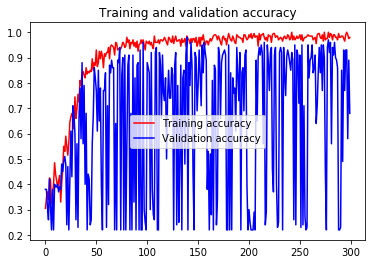

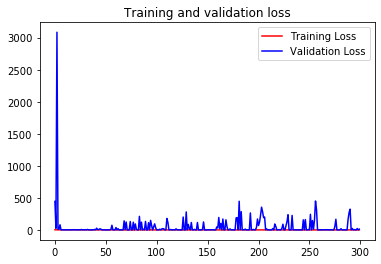

In [24]:
import matplotlib.pyplot as plt
epochs = 300
acc = history.history['acc'][:epochs]
val_acc = history.history['val_acc'][:epochs]
loss = history.history['loss'][:epochs]
val_loss = history.history['val_loss'][:epochs]
print('Mean Training Accuracy = '+str(sum(acc)/len(acc)))
print('Mean Testing Accuracy = '+str(sum(val_acc)/len(val_acc)))
print('Mean Training Loss = '+str(sum(loss)/len(loss)))
print('Mean Testing Loss = '+str(sum(val_loss)/len(val_loss)))
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Picking the Best Learning Rate

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
resnet_model.compile(optimizer = RMSprop(lr = 1e-4),
                    loss='categorical_crossentropy',
                    metrics=['acc'])
resnet_model.summary()

NameError: name 'resnet_model' is not defined

In [14]:
history = resnet_model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=100,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks = [lr_schedule])

Epoch 1/100
Epoch 1/100
100/100 - 77s - loss: 2.8728 - acc: 0.4470 - val_loss: 1.4192 - val_acc: 0.3354
Epoch 2/100
Epoch 1/100
100/100 - 42s - loss: 1.6788 - acc: 0.6280 - val_loss: 4.2697 - val_acc: 0.3232
Epoch 3/100
Epoch 1/100
100/100 - 46s - loss: 1.4780 - acc: 0.7190 - val_loss: 5.6905 - val_acc: 0.3313
Epoch 4/100
Epoch 1/100
100/100 - 63s - loss: 1.2209 - acc: 0.7870 - val_loss: 5.7549 - val_acc: 0.4167
Epoch 5/100
Epoch 1/100
100/100 - 48s - loss: 1.2647 - acc: 0.8080 - val_loss: 19.0199 - val_acc: 0.3516
Epoch 6/100
Epoch 1/100
100/100 - 51s - loss: 0.9833 - acc: 0.8310 - val_loss: 1.8331 - val_acc: 0.7093
Epoch 7/100
Epoch 1/100
100/100 - 52s - loss: 0.8584 - acc: 0.8530 - val_loss: 88.2199 - val_acc: 0.3394
Epoch 8/100
Epoch 1/100
100/100 - 101s - loss: 0.7245 - acc: 0.8510 - val_loss: 38.2281 - val_acc: 0.3354
Epoch 9/100
Epoch 1/100
100/100 - 52s - loss: 0.6308 - acc: 0.8810 - val_loss: 73.8990 - val_acc: 0.3598
Epoch 10/100
Epoch 1/100
100/100 - 55s - loss: 0.5284 - acc

Epoch 1/100
100/100 - 46s - loss: 1.2038 - acc: 0.3350 - val_loss: 1.1211 - val_acc: 0.3252
Epoch 79/100
Epoch 1/100
100/100 - 46s - loss: 1.2309 - acc: 0.3460 - val_loss: 1.4517 - val_acc: 0.3313
Epoch 80/100
Epoch 1/100
100/100 - 47s - loss: 1.2484 - acc: 0.3400 - val_loss: 1.1196 - val_acc: 0.3272
Epoch 81/100
Epoch 1/100
100/100 - 46s - loss: 1.2883 - acc: 0.3380 - val_loss: 1.2067 - val_acc: 0.3333
Epoch 82/100
Epoch 1/100
100/100 - 48s - loss: 1.3297 - acc: 0.3290 - val_loss: 1.1701 - val_acc: 0.3333
Epoch 83/100
Epoch 1/100
100/100 - 46s - loss: 1.3662 - acc: 0.3300 - val_loss: 1.1280 - val_acc: 0.3293
Epoch 84/100
Epoch 1/100
100/100 - 47s - loss: 1.4171 - acc: 0.3460 - val_loss: 1.3140 - val_acc: 0.3394
Epoch 85/100
Epoch 1/100
100/100 - 46s - loss: 1.5541 - acc: 0.3030 - val_loss: 1.3937 - val_acc: 0.3333
Epoch 86/100
Epoch 1/100
100/100 - 46s - loss: 1.5120 - acc: 0.3410 - val_loss: 1.7110 - val_acc: 0.3374
Epoch 87/100
Epoch 1/100
100/100 - 47s - loss: 1.6959 - acc: 0.3260 

[0.0001, 0.1, 0, 3]

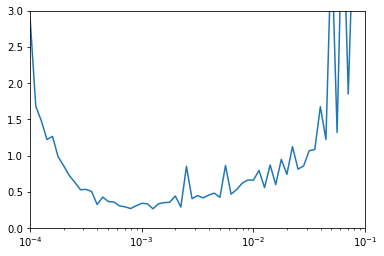

In [16]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 3])

# Save Model Callback

In [19]:
checkpoint_path = "D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)

In [7]:
import datetime
callbacks = myCallback()
model.compile(optimizer = RMSprop(lr = 7e-4),
                    loss='categorical_crossentropy',
                    metrics=['acc'])
history = model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=100,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks = [callbacks,cp_callback])

Epoch 1/100
Epoch 1/100

Epoch 00001: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 32s - loss: 1.1018 - acc: 0.3330 - val_loss: 1.0977 - val_acc: 0.4106
Epoch 2/100
Epoch 1/100

Epoch 00002: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 28s - loss: 1.0840 - acc: 0.3840 - val_loss: 0.9677 - val_acc: 0.6240
Epoch 3/100
Epoch 1/100

Epoch 00003: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 28s - loss: 0.8904 - acc: 0.5850 - val_loss: 0.7080 - val_acc: 0.7012
Epoch 4/100
Epoch 1/100

Epoch 00004: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 24s - loss: 0.6966 - acc: 0.70

100/100 - 30s - loss: 0.1156 - acc: 0.9640 - val_loss: 0.3490 - val_acc: 0.8943
Epoch 33/100
Epoch 1/100

Epoch 00033: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 27s - loss: 0.1148 - acc: 0.9700 - val_loss: 0.1287 - val_acc: 0.9573
Epoch 34/100
Epoch 1/100

Epoch 00034: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 26s - loss: 0.1103 - acc: 0.9630 - val_loss: 0.1456 - val_acc: 0.9492
Epoch 35/100
Epoch 1/100

Epoch 00035: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 29s - loss: 0.0801 - acc: 0.9710 - val_loss: 0.2781 - val_acc: 0.9146
Epoch 36/100
Epoch 1/100

Epoch 00036: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1


Epoch 00064: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 33s - loss: 0.0919 - acc: 0.9760 - val_loss: 0.2278 - val_acc: 0.9411
Epoch 65/100
Epoch 1/100

Epoch 00065: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 31s - loss: 0.0761 - acc: 0.9760 - val_loss: 0.1835 - val_acc: 0.9167
Epoch 66/100
Epoch 1/100

Epoch 00066: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 33s - loss: 0.0972 - acc: 0.9750 - val_loss: 0.3433 - val_acc: 0.8862
Epoch 67/100
Epoch 1/100

Epoch 00067: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 39s - loss: 0.0480 - acc: 0.9860 - val_loss: 0.1217

100/100 - 27s - loss: 0.0475 - acc: 0.9860 - val_loss: 0.1565 - val_acc: 0.9411
Epoch 96/100
Epoch 1/100

Epoch 00096: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 28s - loss: 0.0761 - acc: 0.9780 - val_loss: 0.1610 - val_acc: 0.9472
Epoch 97/100
Epoch 1/100

Epoch 00097: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 26s - loss: 0.0739 - acc: 0.9840 - val_loss: 0.2576 - val_acc: 0.9329
Epoch 98/100
Epoch 1/100

Epoch 00098: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/
100/100 - 27s - loss: 0.0724 - acc: 0.9860 - val_loss: 0.2776 - val_acc: 0.9289
Epoch 99/100
Epoch 1/100

Epoch 00099: saving model to D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1

# Mapping the Loss and Accuracy using MatPlotLib

Mean Training Accuracy = 0.7401999995112419
Mean Testing Accuracy = 0.6512999990582466
Mean Training Loss = 0.5582110178573323
Mean Testing Loss = 10.523328194972544


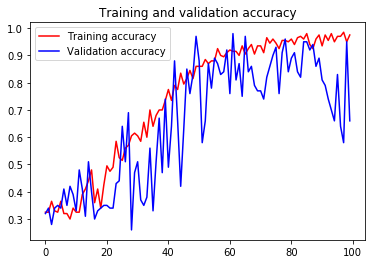

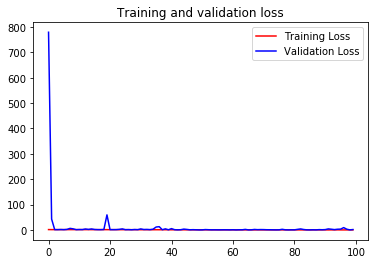

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('Mean Training Accuracy = '+str(sum(acc)/len(acc)))
print('Mean Testing Accuracy = '+str(sum(val_acc)/len(val_acc)))
print('Mean Training Loss = '+str(sum(loss)/len(loss)))
print('Mean Testing Loss = '+str(sum(val_loss)/len(val_loss)))
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Retrieving Saved Model

In [7]:
checkpoint_dir= os.path.dirname('D:/Program Files - Development/Nvidia - Object Detection/Card Detection/models-tf1.7/models/research/Zaid/TExNet/Saved Model/')
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 30-31: malformed \N character escape (<ipython-input-7-9900c927c31c>, line 2)

In [3]:
saved_model = model
saved_model.load_weights(latest)
loss, acc = saved_model.evaluate(test_images,  test_labels, verbose=2)

NameError: name 'model' is not defined

# Inception V3

In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [26]:
inception_v3_model = InceptionV3()
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [27]:
last_layer = inception_v3_model.get_layer('mixed10')
print(last_layer.output_shape)
last_output = last_layer.output
print(last_output)

(None, 8, 8, 2048)
Tensor("mixed10/concat:0", shape=(?, 8, 8, 2048), dtype=float32)


In [28]:
from tensorflow.keras import layers
from tensorflow.keras import Model
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(3,activation='softmax')(x)
inception_v3_model = Model(inception_v3_model.input,x)
inception_v3_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
inception_v3_model.compile(optimizer=RMSprop(lr = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
import datetime
csv_logger = CSVLogger("model_history_log_inceptionv3.csv", append=True)
callbacks = myCallback()
history = inception_v3_model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=300,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks=[csv_logger])

Epoch 1/300
Epoch 1/300
100/100 - 51s - loss: 1.3128 - acc: 0.3150 - val_loss: 934.5235 - val_acc: 0.3600
Epoch 2/300
Epoch 1/300
100/100 - 19s - loss: 1.2347 - acc: 0.3300 - val_loss: 22.1428 - val_acc: 0.2200
Epoch 3/300
Epoch 1/300
100/100 - 19s - loss: 1.2039 - acc: 0.3000 - val_loss: 60.0546 - val_acc: 0.4000
Epoch 4/300
Epoch 1/300
100/100 - 19s - loss: 1.1845 - acc: 0.2800 - val_loss: 474.1201 - val_acc: 0.2200
Epoch 5/300
Epoch 1/300
100/100 - 19s - loss: 1.1728 - acc: 0.3500 - val_loss: 196.2297 - val_acc: 0.3900
Epoch 6/300
Epoch 1/300
100/100 - 19s - loss: 1.1708 - acc: 0.3400 - val_loss: 415.5018 - val_acc: 0.3900
Epoch 7/300
Epoch 1/300
100/100 - 19s - loss: 1.1595 - acc: 0.2900 - val_loss: 4.6789 - val_acc: 0.3100
Epoch 8/300
Epoch 1/300
100/100 - 19s - loss: 1.1566 - acc: 0.3800 - val_loss: 1.1060 - val_acc: 0.3800
Epoch 9/300
Epoch 1/300
100/100 - 19s - loss: 1.1427 - acc: 0.3600 - val_loss: 3.5860 - val_acc: 0.3300
Epoch 10/300
Epoch 1/300
100/100 - 20s - loss: 1.1325 

Epoch 79/300
Epoch 1/300
100/100 - 20s - loss: 0.3095 - acc: 0.9200 - val_loss: 0.6430 - val_acc: 0.7600
Epoch 80/300
Epoch 1/300
100/100 - 21s - loss: 0.1438 - acc: 0.9450 - val_loss: 1.0510 - val_acc: 0.6600
Epoch 81/300
Epoch 1/300
100/100 - 20s - loss: 0.2265 - acc: 0.9450 - val_loss: 0.3994 - val_acc: 0.8900
Epoch 82/300
Epoch 1/300
100/100 - 19s - loss: 0.1960 - acc: 0.9400 - val_loss: 0.4928 - val_acc: 0.8600
Epoch 83/300
Epoch 1/300
100/100 - 21s - loss: 0.1254 - acc: 0.9600 - val_loss: 3.8016 - val_acc: 0.4500
Epoch 84/300
Epoch 1/300
100/100 - 19s - loss: 0.2056 - acc: 0.9600 - val_loss: 0.6871 - val_acc: 0.7800
Epoch 85/300
Epoch 1/300
100/100 - 19s - loss: 0.1990 - acc: 0.9450 - val_loss: 1.2232 - val_acc: 0.6800
Epoch 86/300
Epoch 1/300
100/100 - 20s - loss: 0.2223 - acc: 0.9400 - val_loss: 0.6043 - val_acc: 0.8200
Epoch 87/300
Epoch 1/300
100/100 - 21s - loss: 0.0671 - acc: 0.9850 - val_loss: 0.5624 - val_acc: 0.8300
Epoch 88/300
Epoch 1/300
100/100 - 20s - loss: 0.2173 -

Epoch 157/300
Epoch 1/300
100/100 - 21s - loss: 0.1092 - acc: 0.9800 - val_loss: 0.1796 - val_acc: 0.9200
Epoch 158/300
Epoch 1/300
100/100 - 21s - loss: 0.0281 - acc: 0.9900 - val_loss: 6.6113 - val_acc: 0.5800
Epoch 159/300
Epoch 1/300
100/100 - 19s - loss: 0.0767 - acc: 0.9900 - val_loss: 0.1676 - val_acc: 0.9500
Epoch 160/300
Epoch 1/300
100/100 - 21s - loss: 0.0131 - acc: 0.9950 - val_loss: 0.4547 - val_acc: 0.8900
Epoch 161/300
Epoch 1/300
100/100 - 24s - loss: 0.0574 - acc: 0.9850 - val_loss: 0.8145 - val_acc: 0.8800
Epoch 162/300
Epoch 1/300
100/100 - 20s - loss: 0.1478 - acc: 0.9700 - val_loss: 0.5942 - val_acc: 0.8400
Epoch 163/300
Epoch 1/300
100/100 - 20s - loss: 0.0950 - acc: 0.9800 - val_loss: 0.6604 - val_acc: 0.8200
Epoch 164/300
Epoch 1/300
100/100 - 22s - loss: 0.1395 - acc: 0.9750 - val_loss: 0.6238 - val_acc: 0.8200
Epoch 165/300
Epoch 1/300
100/100 - 20s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.2600 - val_acc: 0.9200
Epoch 166/300
Epoch 1/300
100/100 - 20s - loss

100/100 - 20s - loss: 0.0838 - acc: 0.9850 - val_loss: 0.1653 - val_acc: 0.9700
Epoch 235/300
Epoch 1/300
100/100 - 20s - loss: 0.0765 - acc: 0.9850 - val_loss: 0.0936 - val_acc: 0.9500
Epoch 236/300
Epoch 1/300
100/100 - 21s - loss: 0.0793 - acc: 0.9800 - val_loss: 0.1603 - val_acc: 0.9600
Epoch 237/300
Epoch 1/300
100/100 - 20s - loss: 0.0579 - acc: 0.9750 - val_loss: 0.5769 - val_acc: 0.8800
Epoch 238/300
Epoch 1/300
100/100 - 20s - loss: 0.0090 - acc: 0.9950 - val_loss: 0.1284 - val_acc: 0.9700
Epoch 239/300
Epoch 1/300
100/100 - 20s - loss: 0.1508 - acc: 0.9850 - val_loss: 1.2981 - val_acc: 0.8200
Epoch 240/300
Epoch 1/300
100/100 - 20s - loss: 0.0145 - acc: 0.9950 - val_loss: 0.1415 - val_acc: 0.9600
Epoch 241/300
Epoch 1/300
100/100 - 20s - loss: 1.2365e-04 - acc: 1.0000 - val_loss: 0.2112 - val_acc: 0.9500
Epoch 242/300
Epoch 1/300
100/100 - 20s - loss: 0.1274 - acc: 0.9800 - val_loss: 0.1298 - val_acc: 0.9700
Epoch 243/300
Epoch 1/300
100/100 - 20s - loss: 0.0032 - acc: 1.0000

Mean Training Accuracy = 0.8997500056028366
Mean Testing Accuracy = 0.7825000017384688
Mean Training Loss = 0.2540450170497402
Mean Testing Loss = 8.380022548811342


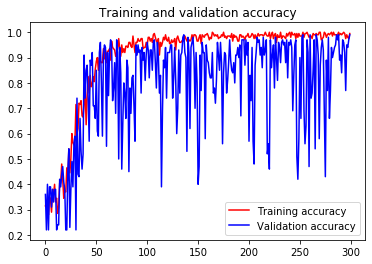

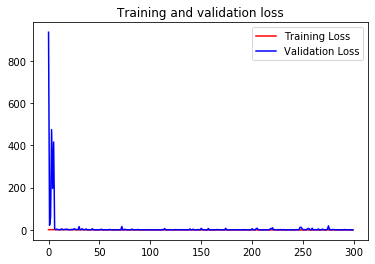

In [32]:
import matplotlib.pyplot as plt
epochs = 300
acc = history.history['acc'][:epochs]
val_acc = history.history['val_acc'][:epochs]
loss = history.history['loss'][:epochs]
val_loss = history.history['val_loss'][:epochs]
print('Mean Training Accuracy = '+str(sum(acc)/len(acc)))
print('Mean Testing Accuracy = '+str(sum(val_acc)/len(val_acc)))
print('Mean Training Loss = '+str(sum(loss)/len(loss)))
print('Mean Testing Loss = '+str(sum(val_loss)/len(val_loss)))
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Inception v4 / Inception Resnet v2

In [4]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [5]:
inception_v4_model = InceptionResNetV2()
inception_v4_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        

activation_180 (Activation)     (None, 8, 8, 192)    0           batch_normalization_180[0][0]    
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 8, 8, 224)    129024      activation_180[0][0]             
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 8, 8, 224)    672         conv2d_181[0][0]                 
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 8, 8, 224)    0           batch_normalization_181[0][0]    
__________________________________________________________________________________________________
conv2d_179 (Conv2D)             (None, 8, 8, 192)    399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
conv2d_182

In [6]:
last_layer = inception_v4_model.get_layer('conv_7b_ac')
print(last_layer.output_shape)
last_output = last_layer.output
print(last_output)

(None, 8, 8, 1536)
Tensor("conv_7b_ac/Relu:0", shape=(?, 8, 8, 1536), dtype=float32)


In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dense(10,activation='softmax')(x)
inception_v4_model = Model(inception_v4_model.input,x)
inception_v4_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

batch_normalization_34 (BatchNo (None, 35, 35, 48)   144         conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 35, 35, 32)   0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 35, 35, 48)   0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 35, 35, 32)   10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 35, 35, 32)   9216        activation_31[0][0]              
__________________________________________________________________________________________________
conv2d_35 

Total params: 54,352,106
Trainable params: 54,291,562
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
inception_v4_model.compile(optimizer = RMSprop(lr = 1e-4),
                    loss='categorical_crossentropy',
                    metrics=['acc'])
#inception_v4_model.summary()

In [13]:
history = inception_v4_model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=100,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks = [lr_schedule])

Epoch 1/100
Epoch 1/100
100/100 - 51s - loss: 1.9344 - acc: 0.3400 - val_loss: 2.0703 - val_acc: 0.3100
Epoch 2/100
Epoch 1/100
100/100 - 46s - loss: 1.3956 - acc: 0.5500 - val_loss: 4.9936 - val_acc: 0.3800
Epoch 3/100
Epoch 1/100
100/100 - 45s - loss: 1.1549 - acc: 0.6300 - val_loss: 4.0019 - val_acc: 0.4900
Epoch 4/100
Epoch 1/100
100/100 - 45s - loss: 1.0321 - acc: 0.6300 - val_loss: 0.8500 - val_acc: 0.7900
Epoch 5/100
Epoch 1/100
100/100 - 45s - loss: 1.0893 - acc: 0.6350 - val_loss: 26.4097 - val_acc: 0.4400
Epoch 6/100
Epoch 1/100
100/100 - 45s - loss: 0.8984 - acc: 0.7400 - val_loss: 8.2035 - val_acc: 0.4600
Epoch 7/100
Epoch 1/100
100/100 - 46s - loss: 0.8456 - acc: 0.7500 - val_loss: 2.7942 - val_acc: 0.4300
Epoch 8/100
Epoch 1/100
100/100 - 45s - loss: 0.8723 - acc: 0.7550 - val_loss: 3.9348 - val_acc: 0.6800
Epoch 9/100
Epoch 1/100
100/100 - 46s - loss: 1.0061 - acc: 0.6650 - val_loss: 3.5528 - val_acc: 0.6300
Epoch 10/100
Epoch 1/100
100/100 - 46s - loss: 0.8509 - acc: 0.

Epoch 79/100
Epoch 1/100
100/100 - 46s - loss: 2.7056 - acc: 0.1550 - val_loss: 2.7398 - val_acc: 0.0900
Epoch 80/100
Epoch 1/100
100/100 - 46s - loss: 2.8237 - acc: 0.0800 - val_loss: 2.7068 - val_acc: 0.1000
Epoch 81/100
Epoch 1/100
100/100 - 49s - loss: 2.9129 - acc: 0.1000 - val_loss: 2.7697 - val_acc: 0.0700
Epoch 82/100
Epoch 1/100
100/100 - 47s - loss: 3.0134 - acc: 0.0800 - val_loss: 2.8138 - val_acc: 0.0800
Epoch 83/100
Epoch 1/100
100/100 - 45s - loss: 3.0855 - acc: 0.0950 - val_loss: 2.7405 - val_acc: 0.1200
Epoch 84/100
Epoch 1/100
100/100 - 48s - loss: 3.0899 - acc: 0.1550 - val_loss: 3.2372 - val_acc: 0.1200
Epoch 85/100
Epoch 1/100
100/100 - 47s - loss: 3.3803 - acc: 0.0750 - val_loss: 3.2215 - val_acc: 0.0800
Epoch 86/100
Epoch 1/100
100/100 - 47s - loss: 3.5411 - acc: 0.0850 - val_loss: 3.2598 - val_acc: 0.1300
Epoch 87/100
Epoch 1/100
100/100 - 48s - loss: 3.9837 - acc: 0.0400 - val_loss: 3.5232 - val_acc: 0.1100
Epoch 88/100
Epoch 1/100
100/100 - 45s - loss: 4.0279 -

[0.0001, 0.1, 0, 3]

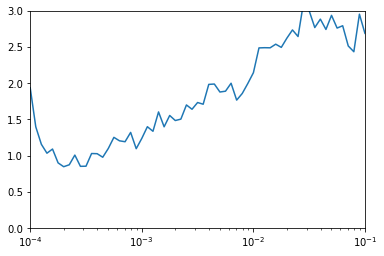

In [14]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 3])

In [11]:
inception_v4_model.compile(optimizer=RMSprop(lr = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
import datetime
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger("model_history_log_inception_resnet_v2_Mnist_Digits_1.csv", append=True)
callbacks = myCallback()
history_inceptionv4 = inception_v4_model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=300,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks = [csv_logger])

Epoch 1/300
Epoch 1/300
100/100 - 176s - loss: 2.5325 - acc: 0.1050 - val_loss: 957.6707 - val_acc: 0.1400
Epoch 2/300
Epoch 1/300
100/100 - 50s - loss: 2.3984 - acc: 0.1300 - val_loss: 356.2817 - val_acc: 0.1100
Epoch 3/300
Epoch 1/300
100/100 - 48s - loss: 2.4175 - acc: 0.1250 - val_loss: 313.2297 - val_acc: 0.0900
Epoch 4/300
Epoch 1/300
100/100 - 47s - loss: 2.4280 - acc: 0.1500 - val_loss: 398.8838 - val_acc: 0.1300
Epoch 5/300
Epoch 1/300
100/100 - 45s - loss: 2.3884 - acc: 0.1100 - val_loss: 2.2642 - val_acc: 0.1900
Epoch 6/300
Epoch 1/300
100/100 - 44s - loss: 2.3830 - acc: 0.1500 - val_loss: 3.9299 - val_acc: 0.2200
Epoch 7/300
Epoch 1/300
100/100 - 45s - loss: 2.3494 - acc: 0.1400 - val_loss: 4.8852 - val_acc: 0.1500
Epoch 8/300
Epoch 1/300
100/100 - 45s - loss: 2.3715 - acc: 0.1650 - val_loss: 54.1946 - val_acc: 0.1900
Epoch 9/300
Epoch 1/300
100/100 - 45s - loss: 2.3522 - acc: 0.1750 - val_loss: 9.9807 - val_acc: 0.1000
Epoch 10/300
Epoch 1/300
100/100 - 45s - loss: 2.3324 

Epoch 79/300
Epoch 1/300
100/100 - 46s - loss: 0.9732 - acc: 0.7100 - val_loss: 1.3180 - val_acc: 0.7200
Epoch 80/300
Epoch 1/300
100/100 - 45s - loss: 0.7791 - acc: 0.7300 - val_loss: 2.2285 - val_acc: 0.4300
Epoch 81/300
Epoch 1/300
100/100 - 47s - loss: 0.9398 - acc: 0.6300 - val_loss: 0.7758 - val_acc: 0.7500
Epoch 82/300
Epoch 1/300
100/100 - 46s - loss: 0.7335 - acc: 0.7450 - val_loss: 3.4830 - val_acc: 0.5400
Epoch 83/300
Epoch 1/300
100/100 - 46s - loss: 0.9871 - acc: 0.6800 - val_loss: 1.6079 - val_acc: 0.5500
Epoch 84/300
Epoch 1/300
100/100 - 47s - loss: 0.9184 - acc: 0.6900 - val_loss: 0.7602 - val_acc: 0.7000
Epoch 85/300
Epoch 1/300
100/100 - 47s - loss: 0.8250 - acc: 0.7050 - val_loss: 1.1270 - val_acc: 0.6000
Epoch 86/300
Epoch 1/300
100/100 - 49s - loss: 0.8202 - acc: 0.7100 - val_loss: 0.7502 - val_acc: 0.7700
Epoch 87/300
Epoch 1/300
100/100 - 47s - loss: 0.8102 - acc: 0.7500 - val_loss: 0.8893 - val_acc: 0.7100
Epoch 88/300
Epoch 1/300
100/100 - 46s - loss: 0.7054 -

Epoch 157/300
Epoch 1/300
100/100 - 46s - loss: 0.6139 - acc: 0.8400 - val_loss: 0.4578 - val_acc: 0.8800
Epoch 158/300
Epoch 1/300
100/100 - 46s - loss: 0.5430 - acc: 0.8400 - val_loss: 0.4103 - val_acc: 0.8600
Epoch 159/300
Epoch 1/300
100/100 - 46s - loss: 0.4711 - acc: 0.8300 - val_loss: 0.3382 - val_acc: 0.8600
Epoch 160/300
Epoch 1/300
100/100 - 45s - loss: 0.4051 - acc: 0.8700 - val_loss: 0.4743 - val_acc: 0.8700
Epoch 161/300
Epoch 1/300
100/100 - 46s - loss: 0.5202 - acc: 0.8400 - val_loss: 0.5488 - val_acc: 0.8600
Epoch 162/300
Epoch 1/300
100/100 - 47s - loss: 0.4591 - acc: 0.8850 - val_loss: 0.8353 - val_acc: 0.7500
Epoch 163/300
Epoch 1/300
100/100 - 46s - loss: 0.3359 - acc: 0.8900 - val_loss: 0.4407 - val_acc: 0.8400
Epoch 164/300
Epoch 1/300
100/100 - 46s - loss: 0.3783 - acc: 0.8750 - val_loss: 1.9303 - val_acc: 0.7600
Epoch 165/300
Epoch 1/300
100/100 - 47s - loss: 0.2910 - acc: 0.9350 - val_loss: 0.6116 - val_acc: 0.9000
Epoch 166/300
Epoch 1/300
100/100 - 49s - loss

Epoch 235/300
Epoch 1/300
100/100 - 46s - loss: 0.1644 - acc: 0.9500 - val_loss: 0.4778 - val_acc: 0.9200
Epoch 236/300
Epoch 1/300
100/100 - 46s - loss: 0.3453 - acc: 0.8950 - val_loss: 0.2892 - val_acc: 0.9100
Epoch 237/300
Epoch 1/300
100/100 - 45s - loss: 0.1643 - acc: 0.9350 - val_loss: 0.4744 - val_acc: 0.8700
Epoch 238/300
Epoch 1/300
100/100 - 46s - loss: 0.3812 - acc: 0.9050 - val_loss: 0.3536 - val_acc: 0.9100
Epoch 239/300
Epoch 1/300
100/100 - 47s - loss: 0.3772 - acc: 0.8800 - val_loss: 0.6741 - val_acc: 0.8900
Epoch 240/300
Epoch 1/300
100/100 - 47s - loss: 0.5073 - acc: 0.8550 - val_loss: 1.1874 - val_acc: 0.8100
Epoch 241/300
Epoch 1/300
100/100 - 46s - loss: 0.3173 - acc: 0.8950 - val_loss: 2.1788 - val_acc: 0.7500
Epoch 242/300
Epoch 1/300
100/100 - 46s - loss: 0.2605 - acc: 0.9250 - val_loss: 1.6197 - val_acc: 0.7600
Epoch 243/300
Epoch 1/300
100/100 - 47s - loss: 0.2080 - acc: 0.9400 - val_loss: 0.2168 - val_acc: 0.9600
Epoch 244/300
Epoch 1/300
100/100 - 48s - loss

Mean Training Accuracy = 0.7393500003467004
Mean Testing Accuracy = 0.7026333323617776
Mean Training Loss = 0.7755691272000802
Mean Testing Loss = 8.478082559750506


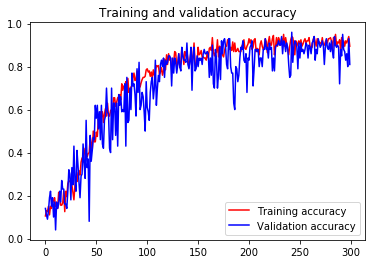

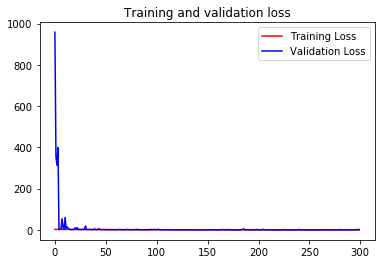

In [13]:
import matplotlib.pyplot as plt
epochs = 300
history = history_inceptionv4
acc = history.history['acc'][:epochs]
val_acc = history.history['val_acc'][:epochs]
loss = history.history['loss'][:epochs]
val_loss = history.history['val_loss'][:epochs]
print('Mean Training Accuracy = '+str(sum(acc)/len(acc)))
print('Mean Testing Accuracy = '+str(sum(val_acc)/len(val_acc)))
print('Mean Training Loss = '+str(sum(loss)/len(loss)))
print('Mean Testing Loss = '+str(sum(val_loss)/len(val_loss)))
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# TExNet Model

In [2]:
filter_temp = 192 #398
filter_temp_ = 256 #512

In [3]:
def Inception_Resnet_AZ(X,filters, stage=1, block=1):
    
    F1,F2,F3,F4 = filters
    #print(X.shape)
    X_shortcut_1 = X
    X_shortcut_2 = X
    
    x1,x2,x3 = Inception_resnet_az_block(X,filters)
    
    X = tf.keras.layers.Concatenate(axis=3)([x1,x2,x3])
    X_shortcut_1 = Conv2D(filter_temp, (1,1),activation = 'relu')(X_shortcut_1)
    
    X = Add()([X,X_shortcut_1])
    
    x1,x2,x3 = Inception_resnet_az_block(X,filters)
    X = tf.keras.layers.Concatenate(axis=3)([x1,x2,x3])
    
    X_shortcut_2 = Conv2D(filter_temp, (1,1),activation = 'relu')(X_shortcut_2)
    
    X = Add()([X,X_shortcut_2])
    
    return X

In [4]:
def Inception_resnet_az_block(X,filters):
    
    F1,F2,F3,F4 = filters
    
    x1a = Conv2D(F1, (1,1))(X)
    x1a = BatchNormalization(axis=3)(x1a)
    x1a = Activation('relu')(x1a)
    x2a = Conv2D(F1, (1,1))(X)
    x2a = BatchNormalization(axis=3)(x2a)
    x2a = Activation('relu')(x2a)
    x3a = Conv2D(F1, (1,1))(X)
    x3a = BatchNormalization(axis=3)(x3a)
    x3a = Activation('relu')(x3a)
    
    x2b = Conv2D(F2, (1,3),padding='same')(x2a)
    x2b = BatchNormalization(axis=3)(x2b)
    x2b = Activation('relu')(x2b)
    x3b = Conv2D(F2, (1,3),padding='same')(x3a)
    x3b = BatchNormalization(axis=3)(x3b)
    x3b = Activation('relu')(x3b)
    
    x2c = Conv2D(F3, (3,1),padding='same')(x2b)
    x2c = BatchNormalization(axis=3)(x2c)
    x2c = Activation('relu')(x2c)
    x3c = Conv2D(F3, (3,1),padding='same')(x3b)
    x3c = BatchNormalization(axis=3)(x3c)
    x3c = Activation('relu')(x3c)
    
    x3d = Conv2D(F4, (3,1),padding='same')(x3c)
    x3d = BatchNormalization(axis=3)(x3d)
    x3d = Activation('relu')(x3d)
    x3d = Conv2D(F4, (1,3),padding='same')(x3d)
    x3d = BatchNormalization(axis=3)(x3d)
    x3d = Activation('relu')(x3d)
    
    x1 = Conv2D(F4, (1,1),activation = 'relu')(x1a)
    x2 = Conv2D(F4, (1,1),activation = 'relu')(x2c)
    x3 = x3d
    return x1,x2,x3

In [5]:
def Inception_Resnet_BZ(X,filters):
    F1,F2,F3,F4 = filters
    #print(X.shape)
    X_shortcut_1 = X
    X_shortcut_2 = X
    
    x1,x2 = Inception_resnet_cz_block(X,filters)
    
    X = tf.keras.layers.Concatenate(axis=3)([x1,x2])
    X_shortcut_1 = Conv2D(filter_temp_, (1,1),activation = 'relu')(X_shortcut_1)#512
    
    X = Add()([X,X_shortcut_1])
    
    x1,x2 = Inception_resnet_cz_block(X,filters)
    X = tf.keras.layers.Concatenate(axis=3)([x1,x2])
    
    X_shortcut_2 = Conv2D(filter_temp_, (1,1),activation = 'relu')(X_shortcut_2)#512
    
    X = Add()([X,X_shortcut_2])
    return X

In [6]:
def Inception_resnet_bc_block(X,filters):
    
    F1,F2,F3,F4 = filters
    
    x1a = Conv2D(F1, (1,1))(X)
    x1a = BatchNormalization(axis=3)(x1a)
    x1a = Activation('relu')(x1a)
    x2a = Conv2D(F1, (1,1))(X)
    x2a = BatchNormalization(axis=3)(x2a)
    x2a = Activation('relu')(x2a)
    
    x2b = Conv2D(F2, (1,5),padding='same')(x2a)
    x2b = BatchNormalization(axis=3)(x2b)
    x2b = Activation('relu')(x2b)
    
    x2c = Conv2D(F3, (5,1),padding='same')(x2b)
    x2c = BatchNormalization(axis=3)(x2c)
    x2c = Activation('relu')(x2c)
    
    x1 = Conv2D(F4, (1,1),activation = 'relu')(x1a)
    x2 = Conv2D(F4, (1,1),activation = 'relu')(x2c)
    
    return x1,x2

In [7]:
def Inception_Resnet_CZ(X,filters):
    F1,F2,F3,F4 = filters
    #print(X.shape)
    X_shortcut_1 = X
    X_shortcut_2 = X
    
    x1,x2 = Inception_resnet_cz_block(X,filters)
    
    X = tf.keras.layers.Concatenate(axis=3)([x1,x2])
    X_shortcut_1 = Conv2D(filter_temp_, (1,1),activation = 'relu')(X_shortcut_1)
    
    X = Add()([X,X_shortcut_1])
    
    x1,x2 = Inception_resnet_cz_block(X,filters)
    X = tf.keras.layers.Concatenate(axis=3)([x1,x2])
    
    X_shortcut_2 = Conv2D(filter_temp_, (1,1),activation = 'relu')(X_shortcut_2)
    
    X = Add()([X,X_shortcut_2])
    return X

In [8]:
def Inception_resnet_cz_block(X,filters):
    
    F1,F2,F3,F4 = filters
    
    x1a = Conv2D(F1, (1,1))(X)
    x1a = BatchNormalization(axis=3)(x1a)
    x1a = Activation('relu')(x1a)
    x2a = Conv2D(F1, (1,1))(X)
    x2a = BatchNormalization(axis=3)(x2a)
    x2a = Activation('relu')(x2a)
    
    x2b = Conv2D(F2, (1,7),padding='same')(x2a)
    x2b = BatchNormalization(axis=3)(x2b)
    x2b = Activation('relu')(x2b)
    
    x2c = Conv2D(F3, (7,1),padding='same')(x2b)
    x2c = BatchNormalization(axis=3)(x2c)
    x2c = Activation('relu')(x2c)
    
    x1 = Conv2D(F4, (1,1),activation = 'relu')(x1a)
    x2 = Conv2D(F4, (1,1),activation = 'relu')(x2c)
    
    return x1,x2

In [9]:
def Texnet(input_shape=(299,299,3), classes=3):
    X_input = Input(input_shape)
    X = Conv2D(32,(7,7),strides = (2,2))(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    for i in range(5):
        X = Inception_Resnet_AZ(X,[8,16,32,64])
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    for i in range(10):
        X = Inception_Resnet_BZ(X,[16,32,64,128])
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    for i in range(5):
        X = Inception_Resnet_CZ(X,[16,32,64,128])
    X = AveragePooling2D((4,4))(X)
    X = Flatten()(X)
    X = Dense(512,activation = 'relu')(X)
    X = Dense(classes, activation = 'softmax')(X)
    model = Model(inputs=X_input,outputs = X,name='TExNet')
    return model

In [10]:
model = Texnet((299,299,3),10)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "TExNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 147, 147, 32) 4736        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 147, 147, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 147, 147, 32) 0           batch_normalization[0][0]        
____________

Total params: 5,777,402
Trainable params: 5,764,698
Non-trainable params: 12,704
__________________________________________________________________________________________________


In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
model.compile(optimizer = RMSprop(lr = 1e-4),
                    loss='categorical_crossentropy',
                    metrics=['acc'])

In [24]:
history = model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = 100,
                             epochs=100,
                             validation_steps = 50,
                             verbose = 2,
                             callbacks = [lr_schedule])

Epoch 1/100
Epoch 1/100
100/100 - 207s - loss: 2.8227 - acc: 0.1250 - val_loss: 2.3170 - val_acc: 0.0900
Epoch 2/100
Epoch 1/100
100/100 - 72s - loss: 2.6151 - acc: 0.1550 - val_loss: 2.3936 - val_acc: 0.0800
Epoch 3/100
Epoch 1/100
100/100 - 76s - loss: 2.6097 - acc: 0.0950 - val_loss: 2.3775 - val_acc: 0.1200
Epoch 4/100
Epoch 1/100
100/100 - 77s - loss: 2.5367 - acc: 0.1200 - val_loss: 2.5978 - val_acc: 0.1200
Epoch 5/100
Epoch 1/100
100/100 - 76s - loss: 2.5482 - acc: 0.1150 - val_loss: 2.3980 - val_acc: 0.1800
Epoch 6/100
Epoch 1/100
100/100 - 78s - loss: 2.3838 - acc: 0.1950 - val_loss: 2.3504 - val_acc: 0.1200
Epoch 7/100
Epoch 1/100
100/100 - 78s - loss: 2.3188 - acc: 0.1600 - val_loss: 2.3385 - val_acc: 0.2800
Epoch 8/100
Epoch 1/100
100/100 - 77s - loss: 2.2395 - acc: 0.2700 - val_loss: 12.9566 - val_acc: 0.1400
Epoch 9/100
Epoch 1/100
100/100 - 76s - loss: 2.1469 - acc: 0.2700 - val_loss: 2.0765 - val_acc: 0.2800
Epoch 10/100
Epoch 1/100
100/100 - 78s - loss: 2.1258 - acc: 0

Epoch 79/100
Epoch 1/100
100/100 - 74s - loss: 2.7213 - acc: 0.1200 - val_loss: 2.9017 - val_acc: 0.1300
Epoch 80/100
Epoch 1/100
100/100 - 76s - loss: 2.7905 - acc: 0.1100 - val_loss: 2.8210 - val_acc: 0.0900
Epoch 81/100
Epoch 1/100
100/100 - 75s - loss: 2.9124 - acc: 0.0950 - val_loss: 2.7949 - val_acc: 0.1200
Epoch 82/100
Epoch 1/100
100/100 - 73s - loss: 2.9796 - acc: 0.0900 - val_loss: 2.8781 - val_acc: 0.1000
Epoch 83/100
Epoch 1/100
100/100 - 75s - loss: 3.0959 - acc: 0.1250 - val_loss: 3.1345 - val_acc: 0.1200
Epoch 84/100
Epoch 1/100
100/100 - 74s - loss: 3.2139 - acc: 0.1250 - val_loss: 3.1592 - val_acc: 0.0700
Epoch 85/100
Epoch 1/100
100/100 - 75s - loss: 3.3862 - acc: 0.1000 - val_loss: 5.0269 - val_acc: 0.1300
Epoch 86/100
Epoch 1/100
100/100 - 76s - loss: 3.6362 - acc: 0.0600 - val_loss: 3.5464 - val_acc: 0.0700
Epoch 87/100
Epoch 1/100
100/100 - 74s - loss: 3.5147 - acc: 0.1450 - val_loss: 4.5492 - val_acc: 0.1000
Epoch 88/100
Epoch 1/100
100/100 - 74s - loss: 4.0576 -

[0.0001, 100.0, 0, 3]

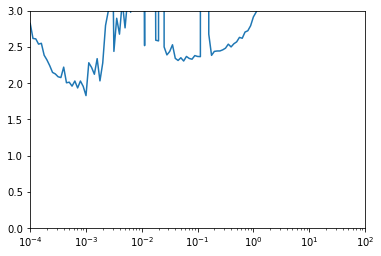

In [25]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e2, 0, 3])

In [29]:
model.compile(optimizer = RMSprop(lr = 1e-3),
                    loss='categorical_crossentropy',
                    metrics=['acc'])
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [30]:
import datetime
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger("model_history_log_texnet_test_14.csv", append=True)
#callbacks = myCallback()
print('steps_per_epoch'+str(len(train_generator)*0.1))
print('Validation_per_epoch'+str(len(test_generator)*.2))
history = model.fit_generator(train_generator,
                             validation_data = test_generator,
                             steps_per_epoch = len(train_generator)*0.1,
                             epochs=50,
                             validation_steps = len(test_generator)*.2,
                             verbose = 2,
                             callbacks = [csv_logger, cp_callback])

steps_per_epoch546.7
Validation_per_epoch306.8
Epoch 1/50
Epoch 1/50

Epoch 00001: val_loss improved from inf to 42.69495, saving model to training_2/cp.ckpt
547/546 - 656s - loss: 2.3703 - acc: 0.1450 - val_loss: 42.6950 - val_acc: 0.1015
Epoch 2/50
Epoch 1/50

Epoch 00002: val_loss improved from 42.69495 to 4.73728, saving model to training_2/cp.ckpt
547/546 - 518s - loss: 1.5933 - acc: 0.4488 - val_loss: 4.7373 - val_acc: 0.1591
Epoch 3/50
Epoch 1/50

Epoch 00003: val_loss improved from 4.73728 to 0.55970, saving model to training_2/cp.ckpt
547/546 - 490s - loss: 1.0994 - acc: 0.6427 - val_loss: 0.5597 - val_acc: 0.7932
Epoch 4/50
Epoch 1/50

Epoch 00004: val_loss improved from 0.55970 to 0.44338, saving model to training_2/cp.ckpt
547/546 - 467s - loss: 0.8931 - acc: 0.7154 - val_loss: 0.4434 - val_acc: 0.8713
Epoch 5/50
Epoch 1/50

Epoch 00005: val_loss did not improve from 0.44338
547/546 - 456s - loss: 1.0537 - acc: 0.6542 - val_loss: 11.1993 - val_acc: 0.1059
Epoch 6/50
Epoch 1

Mean Training Accuracy = 0.8377231845259666
Mean Testing Accuracy = 0.7929098871350289
Mean Training Loss = 0.8090831585979319
Mean Testing Loss = 1.926634857055434


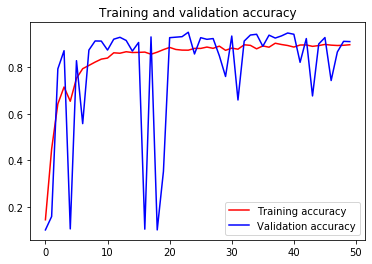

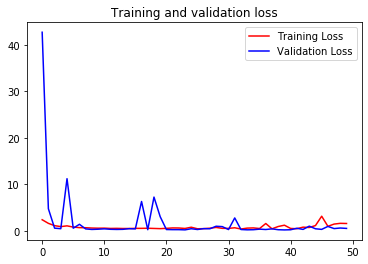

In [31]:
import matplotlib.pyplot as plt
epochs = 50
acc = history.history['acc'][:epochs]
val_acc = history.history['val_acc'][:epochs]
loss = history.history['loss'][:epochs]
val_loss = history.history['val_loss'][:epochs]
print('Mean Training Accuracy = '+str(sum(acc)/len(acc)))
print('Mean Testing Accuracy = '+str(sum(val_acc)/len(val_acc)))
print('Mean Training Loss = '+str(sum(loss)/len(loss)))
print('Mean Testing Loss = '+str(sum(val_loss)/len(val_loss)))
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
latest_checkpoint = tf.train.latest_checkpoint("training_2/")
print(latest_checkpoint)
# Load the previously saved weights
model.load_weights(latest_checkpoint)

training_2/cp.ckpt


(1, 299, 299, 3)


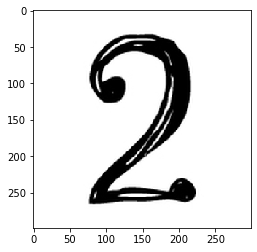

In [15]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
path = 'C:/Users/zaidg/Downloads/2.jpeg'
img = image.load_img(path, target_size=(299, 299))
x = image.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x, axis=0)
print(x.shape)
# Re-evaluate the model
#print(image.load_img(path, target_size=(299, 299)))
#print(model.predict(x))

[[7.3892364e-10 4.3169638e-18 1.2332550e-03 1.9423024e-01 3.9475804e-08
  8.0450940e-01 3.5783064e-08 3.6665764e-07 2.3623697e-05 3.1306686e-06]]


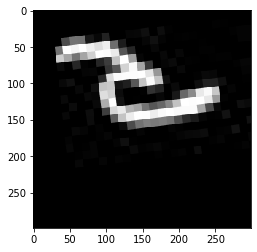

In [16]:
#model.predict(test_generator)
x = image.img_to_array(train_generator[0][0][1])
plt.imshow(x)
x = np.expand_dims(x, axis=0)
result = model.predict(x)
print(result)

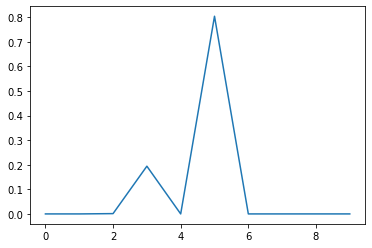

In [17]:
plt.plot(result[0])
plt.show()

[0.34, 0.87, 0.8, 0.12, 0.9, 0.135, 0.96, 0.9533333, 0.5733333, 0.82666665, 0.79333335, 0.92720556, 0.94245386, 0.95059717]


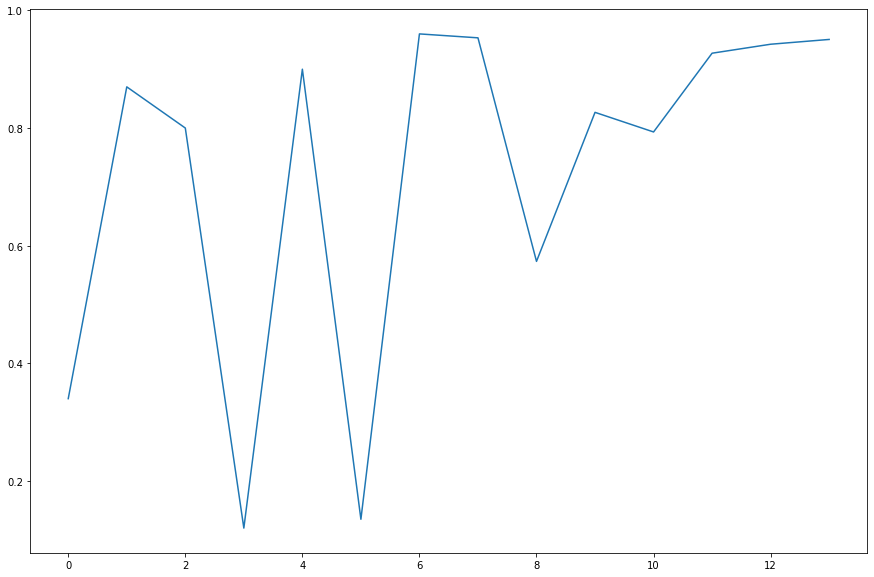

In [87]:
list_acc = []
for i in range(1,15):
    table = pd.read_csv("model_history_log_texnet_test_"+str(i)+".csv")
    list_acc.append(max(table['val_acc']))
print(list_acc)
plt.figure(figsize=(15,10))
plt.plot(list_acc)
plt.show()